# Automated Benchmarking with Profet and Emukit

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

### --- Figure config
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
LEGEND_SIZE = 15
TITLE_SIZE = 25
AXIS_SIZE = 50
FIG_SIZE = (16.0, 9.0)

A central part of developing new Bayesian optimization methods is to emprically compare the to other exisiting methods.
Some people consider this to be a rather daunting task that often causes headaches, since there are a lot of things that could go wrong.
Particularly, if you want to apply your new method for hyperparameter optimization, things can get hairy since
the most benchmarks are extremly expensive which usually slows down your developing process

To speed up the development of hyperparameter optimziation methods, surrogate benchmarks [[Eggensperger et al, 2016]](#4.-References) became quite popular recently. They are regression models trained on offline generate data from the original benchmark such that they can mimic the real objective function. Now, instead of evaluating the original expensive function, one can simply use the prediction of the regression which is substantially cheaper to obtain.

However, usually just a handful of these surrogates are available which makes it hard to draw reliable conclusions whether a new method really performs better than a baseline or it simply overfits on a specific surrogate.

The general idea of Profet [[Klein et al, 2019]](#4.-References), is to train a generative meta-model across different tasks, i.e the same hyperparameter optimization problem with the same domain but on different datasets that allows to draw an arbitraty amount of new benchmarks in a parameteric function.
Typical tasks are, for instance, optimize the regularization parameter $C$ and kernel parameter $\gamma$ of a SVM on different classification datasets.

In the first section of this notebook we will have a look on Profet's underlying meta-model for task generation base on a simple 1-dimensional toy problem.
Then, we will see how we can use Emukit to automatically benchmark and analyze Bayesian optimization methods across 1000 tasks.

### Navigation

1. [The Meta Model](#1.-The-Meta-Model)

2. [Automated Benchmarking](#2.-Automated-Benchmarking)

3. [Conclusions](#3.-Conclusions)

4. [References](#4.-References)

## 1. The Meta Model

In hyperparameter optimization we are given a machine learning algorithm $A$ and a dataset $D$ and we want to find the 
right hyperparameters of $A$, encoded as a numerical vector $\mathbf{x} \in \mathcal{X} \subset \mathbb{R}^d$, such that we minimize $\mathbf{x}_{\star} \in  \text{argmin } f(\mathbf{x})$ the validation error $f: \mathcal{X} \rightarrow \mathbb{R}$ on $D$.

In practice, we often have to optimize the hyperparameters of the same algorithm with a fix input domain $\mathcal{X}$ for different datasets $D_0, ..., D_M$. 
For instance, we want to find the right learning rate of a CNN on different image classification benchmarks such as CIFAR-10 or Imagenet.
We refer to each of those problems as tasks $t_0, ..., t_m$ and assume that each task $t$ has an associated objective function $f_t$.
Since each task is based on the same algorithm, CNN in this case, and the datasets are somewhat similar, we assume that all tasks are related, in a sense that all $f_t$ share some characteristics.
We can state this more formally, by saying that each task $t$ is sampled from a underlying distribution $t \sim p(t)$.

The general idea of Profet is to first learn a meta model $\hat{p}(t | \mathcal{D})$, based on offline generated data $\mathcal{D}$ that approximated $p(t)$ ,which then can be use to generate new tasks $t \sim \hat{p}(t | \mathcal{D})$ such that we can use it to benchmark new hyperparameter optimization methods efficiently.



To visualize the general concept of Profet's meta model, we will use the one-dimensional Forrester function as a toy example:

$$
f(x) = (ax - 2)^2 \sin(bx - 4)
$$

and we can generate different tasks by simply using different values for the constants $a, b$.


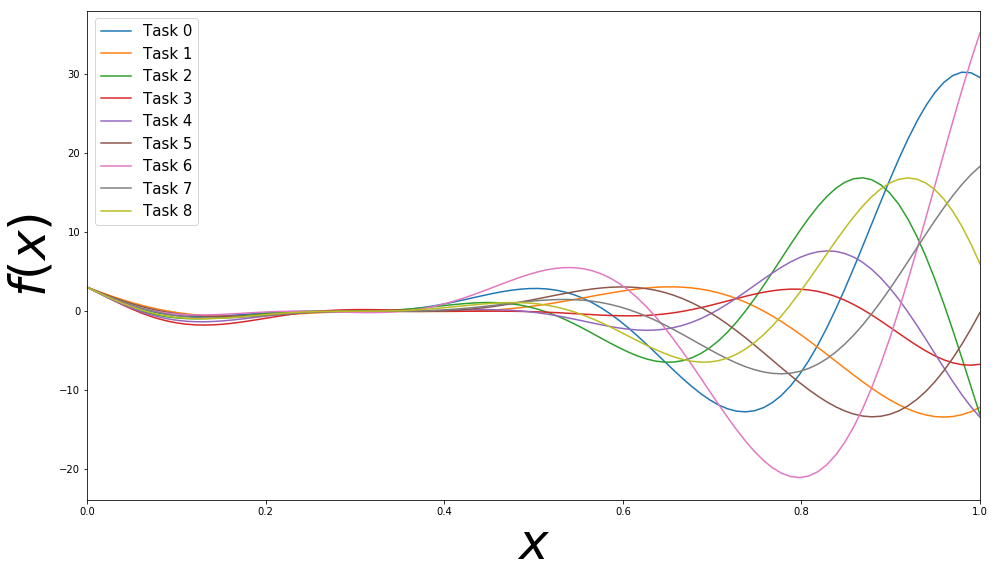

In [18]:
class forrester(object):
    def __init__(self, a=6, b=12):
        self.a = a
        self.b = b

    def __call__(self, X):
        fval = ((self.a*X -2)**2)*np.sin(self.b*X-4)
        return fval

x_plot = np.linspace(0, 1, 100)

a = [7.69846698, 6.0046603,  7.11598319, 4.70129178,
 5.80250748, 6.54354444, 8.40432547, 6.31587167, 6.70531518]
b = [12.28027407,  9.42179065, 13.95012807, 15.39765053,
 14.61343369, 10.27559627, 11.31587582, 11.67305894, 13.15152616]

T = len(a)  # the number of tasks

plt.figure(figsize=FIG_SIZE)
funcs = []
for i in range(T):
    f = forrester(a[i],b[i])
    plt.plot(x_plot, f(x_plot), "C%d" % (i % 10), label="Task %d" % i)
    funcs.append(f)

plt.legend(fontsize=LEGEND_SIZE)
plt.xlim(0, 1)
plt.ylabel(r"$f(x)$", fontsize=AXIS_SIZE)
plt.xlabel(r"$x$", fontsize=AXIS_SIZE)

plt.show()

Now in order to train our meta-model, we first need to collect some data. For that, we generate datapoints $\mathbf{X} = \{\mathbf{x}_0, ... \mathbf{x}_N\}$ by using a Sobol sequence, which is a popular experimental design strategy.
Note that, we could also use any other strategies such as random sampling or Latin hypercube sampling but a Sobol sequence usually gives a better coverage of the whole input space.

Afterwards we will evaluate every $\mathbf{x}_i \in \mathbf{X}$ on each of the $T=9$ tasks and, for each $\mathbf{x_i}$, obtain the corresponding function values $\mathbf{y}_i = \{y_0, ... y_T\}$. We denote all function values of all datapoints by $\mathbf{Y} = \{\mathbf{y}_0, ... \mathbf{y}_N\}$.

Text(0.5, 0, '$x$')

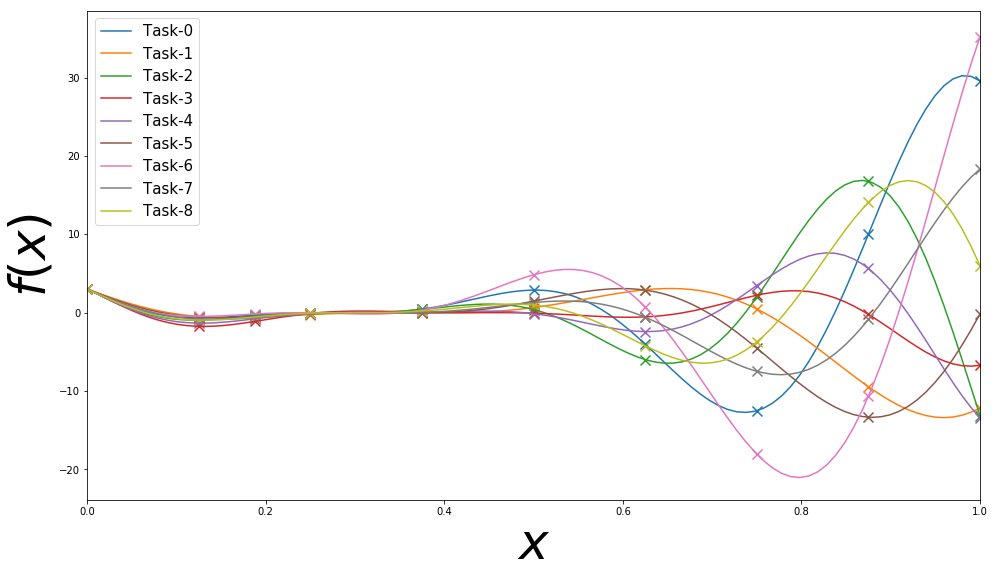

In [19]:
import sobol_seq

N = 10  # the number of datapoints of the Sobol grid

X = sobol_seq.i4_sobol_generate(1, N - 2)
# we also add the first and last point of the input space to get a better coverage of the function
X = np.append(X, np.array([[0]]), axis=0)
X = np.append(X, np.array([[1]]), axis=0)

Y = np.zeros([T, N])
index_tasks = []

plt.figure(figsize=FIG_SIZE)
for i in range(T):
    
    y = funcs[i](X)[:, 0]
    Y[i] = y
    index_tasks.extend([i] * N)
    
    plt.scatter(X, y, color="C%d" % (i % 10), marker="x", s=100)
    plt.plot(x_plot, funcs[i](x_plot), "C%d" % (i % 10), label="Task-%d" % i)

index_tasks = np.array(index_tasks)

plt.legend(fontsize=LEGEND_SIZE)
plt.xlim(0, 1)
plt.ylabel(r"$f(x)$", fontsize=AXIS_SIZE)
plt.xlabel(r"$x$", fontsize=AXIS_SIZE)

Now, with all our observed function values $\mathbf{Y}$, we learn a latent embedding $q: \mathbb{R}^d \rightarrow \mathbb{R}^q$ such that we can encode each task $t$ by a feature vector $\mathbf{h_t} \in \mathbb{R}^q$.
More precisely, we use BayesianGPLVM [[Titsias and Lawrence, 2010]](#4.-References), which based on variational inference, learns a posterior over task embeddings $p(\mathbf{h_t} \mid D)$.

In [5]:
import GPy
from copy import deepcopy
from GPy.models import BayesianGPLVM

def normalize_Y(Y, indexD):
    max_idx = np.max(indexD)
    Y_mean = np.zeros(max_idx+1)
    Y_std = np.zeros(max_idx+1)
    for i in range(max_idx+1):
        Y_mean[i] = Y[indexD == i].mean()
        Y_std[i] = Y[indexD == i].std() + 1e-8
        Y[indexD == i] = (Y[indexD == i] - Y_mean[i])/Y_std[i]
    return Y, Y_mean[:, None], Y_std[:, None]

Y_norm, _, _ = normalize_Y(deepcopy(Y.flatten()), index_tasks)

num_inducing_lvm = 50
Q_h = 2  # the dimensionality of the latent space

kern_row = GPy.kern.Matern52(Q_h, ARD=True)

m_lvm = BayesianGPLVM(Y_norm.reshape(T, N), Q_h, kernel=kern_row,
                      num_inducing=num_inducing_lvm)
m_lvm.optimize(max_iters=10000, messages=0)

The plot below shows now our latent task embedding. Each Gaussian blop represents $p(\mathbf{h}_t \mid D)$ for one of our tasks. We can trivially sample a new laten task embedding from the posterior over our latent space, by first sampling $i \sim \text{Uniform}(0, T)$ and then sampling from the associated Gaussian distribution $\mathbf{h}_{\star} \sim p(\mathbf{h}_i \mid D)$.

(-0.4, 0.4)

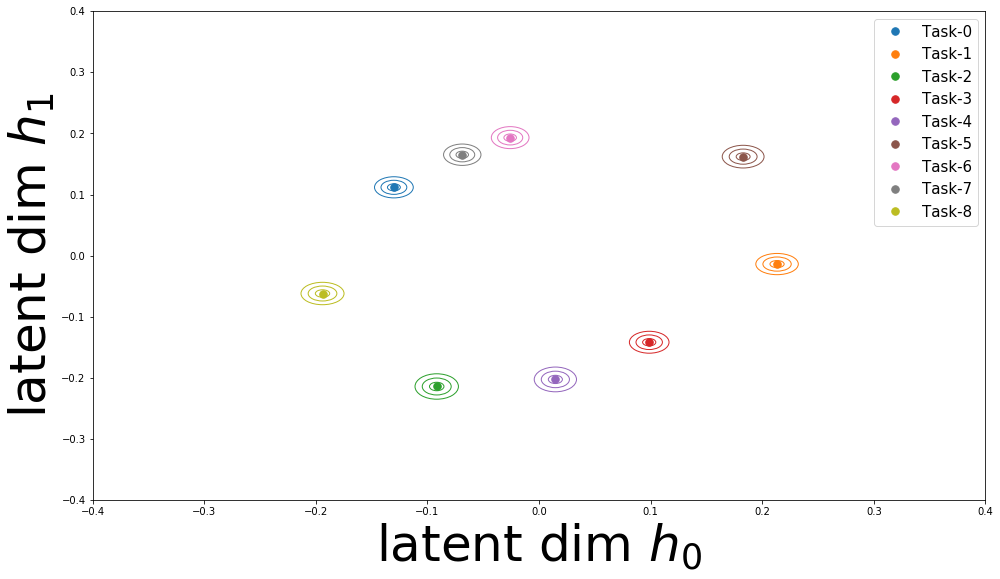

In [6]:
ls = np.array([m_lvm.kern.lengthscale[0], m_lvm.kern.lengthscale[1]])
mean = m_lvm.X.mean / ls
std = np.sqrt(m_lvm.X.variance) / ls

fig = plt.figure(figsize=FIG_SIZE)
ax = fig.gca()

from matplotlib.patches import Ellipse
for i in range(T):
    e = Ellipse(xy=mean[i],
                width=std[i,0], height=std[i,1], fill=False, color="C%d" % (i % 10))
    ax.add_artist(e)
    e = Ellipse(xy=mean[i],
                width=2*std[i,0], height=2*std[i,1], fill=False, color="C%d" % (i % 10))
    ax.add_artist(e)
    e = Ellipse(xy=mean[i],
                width=3*std[i,0], height=3*std[i,1], fill=False, color="C%d" % (i % 10))
    ax.add_artist(e)

[plt.plot(mean[i,0], mean[i,1], color="C%d" % (i % 10), linestyle="None", marker=".",
          label="Task-%d" % i, markersize=15) for i in range(T)]

plt.legend(fontsize=LEGEND_SIZE)
plt.ylabel(r"latent dim $h_1$", fontsize=AXIS_SIZE)
plt.xlabel(r"latent dim $h_0$", fontsize=AXIS_SIZE)
plt.xlim(-.4, .4)
plt.ylim(-.4, .4)

Equipped with our probabilistic encoder, we will train now a probablistic multi-task model $p(y_t \mid \mathbf{x}, \mathbf{h_t})$ [[Swersky et al, 2013]](#4.-References)[[Springenberg et al, 2016]](#4.-References) that, given a hyperparameter configuration $\mathbf{x}$ and a task vector $\mathbf{h_t}$ predicts the corresponding function value $y_t$.

To generate training data, for each data point $\mathbf{x}_i \in \mathbf{X}$ and $y_i \in \mathbf{Y}$, we sample $H$ task vectors $\mathbf{h}_t \sim p(\mathbf{h}_i | D)$. We use the Bayesian neural networks model described by [[Springenberg et al, 2016]](#4.-References) to sample a set of $M$ weights $\{\theta_0, \ldots, \theta_M\}$ from :
$$
p(\theta,  D) = \frac{1}{N} \sum_n \frac{1}{H} \sum_j log p(y_n \mid \mathbf{x}_n, \mathbf{h}_{nj})
$$

In [11]:
ls = np.array([m_lvm.kern.lengthscale[i] for i in range(m_lvm.kern.lengthscale.shape[0])])

task_features_mean = np.array(m_lvm.X.mean / ls)
task_features_std = np.array(np.sqrt(m_lvm.X.variance) / ls)
X_train = []
Y_train = []
t_index_train = []
for i, xi in enumerate(X):
    for idx in range(T):

        for _ in range(5):
            ht = task_features_mean[idx] + task_features_std[idx] * np.random.randn(ls.shape[0])

            x = np.concatenate((xi, ht), axis=0)
            X_train.append(x)
            Y_train.append(Y[idx, i])
            t_index_train.append(idx)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
t_index_train = np.array(t_index_train)

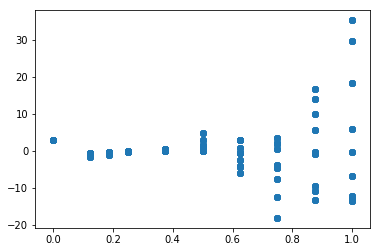

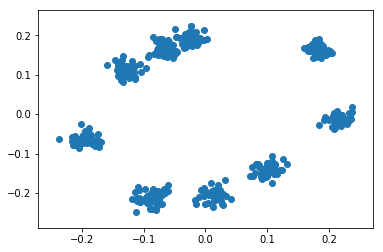

In [14]:
plt.scatter(X_train[:, 0], Y_train)
plt.show()
plt.scatter(X_train[:, 1],X_train[:, 2])



In [17]:
np.save("/home/kleinaa/X_train.npy", X_train)
np.save("/home/kleinaa/Y_train.npy", Y_train)

In [15]:
from emukit.examples.profet.meta_benchmarks.architecture import get_architecture
from pybnn.bohamiann import Bohamiann
import torch
import torch.nn as nn


def get_default_network(input_dimensionality: int) -> torch.nn.Module:
    class AppendLayer(nn.Module):
        def __init__(self, bias=True, *args, **kwargs):
            super().__init__(*args, **kwargs)
            if bias:
                self.bias = nn.Parameter(torch.DoubleTensor(1, 1))
            else:
                self.register_parameter('bias', None)

        def forward(self, x):
            return torch.cat((x, self.bias * torch.ones_like(x)), dim=1)

    def init_weights(module):
        if type(module) == AppendLayer:
            nn.init.constant_(module.bias, val=np.log(1e-2))
        elif type(module) == nn.Linear:
#             nn.init.kaiming_normal_(module.weight, mode="fan_in", nonlinearity="linear")
            nn.init.xavier_normal_(module.weight)
            
            nn.init.constant_(module.bias, val=0.0)

    return nn.Sequential(
        nn.Linear(input_dimensionality, 100), nn.Tanh(),
        nn.Linear(100, 1),
        AppendLayer()
    ).apply(init_weights)

model = Bohamiann(get_network=get_default_network, print_every_n_steps=1000)
model.train(X_train, Y_train, num_steps=90001,
            num_burn_in_steps=80000, keep_every=100,
            lr=1e-2, verbose=True, batch_size=5)

Step     1000 : NLL =  1.6630e+01 MSE = 5.0114e+01 Time =  2.37
Step     2000 : NLL =  7.4194e+00 MSE = 4.5696e+01 Time =  4.76
Step     3000 : NLL =  5.3795e+00 MSE = 4.3303e+01 Time =  7.10
Step     4000 : NLL =  4.9993e+00 MSE = 4.2052e+01 Time =  9.49
Step     5000 : NLL =  4.9400e+00 MSE = 4.1238e+01 Time = 11.78
Step     6000 : NLL =  4.8491e+00 MSE = 3.9672e+01 Time = 13.93
Step     7000 : NLL =  4.7629e+00 MSE = 3.7374e+01 Time = 16.38
Step     8000 : NLL =  4.8115e+00 MSE = 3.5697e+01 Time = 18.93
Step     9000 : NLL =  4.8417e+00 MSE = 3.3936e+01 Time = 21.68
Step    10000 : NLL =  4.5476e+00 MSE = 2.7821e+01 Time = 24.32
Step    11000 : NLL =  4.5065e+00 MSE = 2.5048e+01 Time = 26.95
Step    12000 : NLL =  4.3614e+00 MSE = 2.1043e+01 Time = 29.55
Step    13000 : NLL =  4.2781e+00 MSE = 1.8233e+01 Time = 32.14
Step    14000 : NLL =  3.9197e+00 MSE = 1.4390e+01 Time = 34.70
Step    15000 : NLL =  3.9065e+00 MSE = 1.2940e+01 Time = 37.60
Step    16000 : NLL =  3.8229e+00 MSE = 

KeyboardInterrupt: 

To generate a new task $t_{\star}$, we need the corresponding objective function $f_{t_{\star}}$ in a parameteric form such that we can evaluate it later at any $\mathbf{x} \in \mathcal{X}$.
Since our multi-task model $p(y_t \mid \mathbf{x}, \mathbf{h_t})$ is a Bayesian neural network we can interpret each $\theta_i$  as a function sample. 
Now to sample a $f_{t_{\star}}$, we do the following steps:
   - sample a $\mathbf{h}_{\star}$ which will be fixed 
   - pick a random $\theta_i$

Everytime we evaluate $f_{t_{\star}}$ at any $\mathbf{x} \in \mathcal{X}$, we first concatenate it to our task embedding $\mathbf{h}_{\star}$ and then feed it to our neural network with weights $\theta_i$.

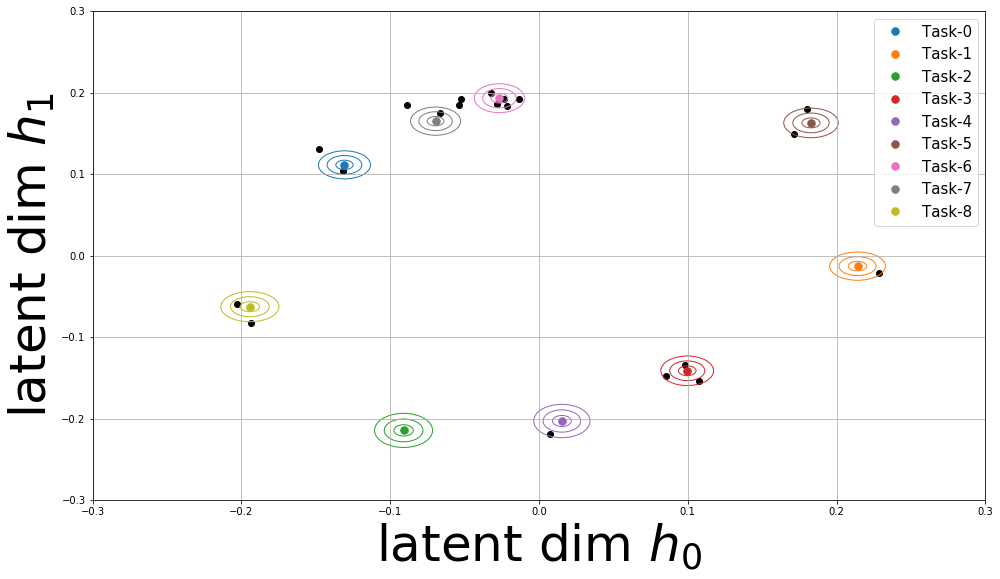

Text(0.5, 0, '$x$')

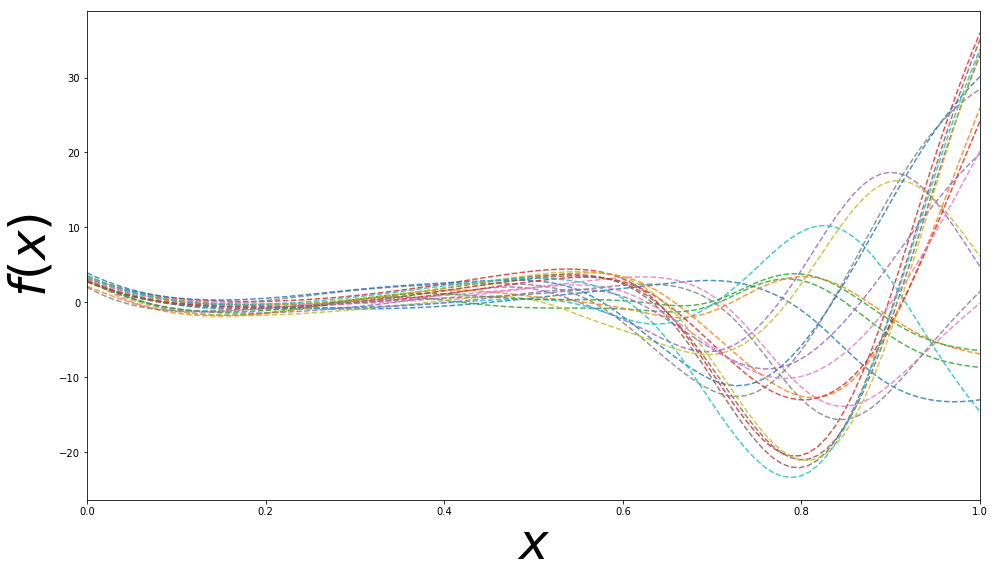

In [16]:
from matplotlib.patches import Ellipse

n_samples = 20
sampled_h = np.zeros([n_samples , ls.shape[0]])
counter = 0

for i in range(n_samples):
    idx = np.random.randint(T)
    ht = task_features_mean[idx] + task_features_std[idx] * np.random.randn(ls.shape[0])
    sampled_h[i] = ht
    
fig = plt.figure(figsize=FIG_SIZE)        
plt.scatter(sampled_h[:, 0], sampled_h[:, 1], c="k")
ax = plt.axes()
for i in range(T):
    e = Ellipse(xy=mean[i],
                width=std[i,0], height=std[i,1], fill=False, color="C%d" % (i % 10))
    ax.add_artist(e)
    e = Ellipse(xy=mean[i],
                width=2*std[i,0], height=2*std[i,1], fill=False, color="C%d" % (i % 10))
    ax.add_artist(e)
    e = Ellipse(xy=mean[i],
                width=3*std[i,0], height=3*std[i,1], fill=False, color="C%d" % (i % 10))
    ax.add_artist(e)

[plt.plot(mean[i,0], mean[i,1], color="C%d" % (i % 10), linestyle="None", marker=".",
          label="Task-%d" % i, markersize=15) for i in range(T)]

plt.legend(fontsize=LEGEND_SIZE)
plt.grid(True)
plt.ylabel(r"latent dim $h_1$", fontsize=AXIS_SIZE)
plt.xlabel(r"latent dim $h_0$", fontsize=AXIS_SIZE)
plt.xlim(-.3, .3)
plt.ylim(-.3, .3)
plt.show()

plt.figure(figsize=FIG_SIZE) 
for i in range(n_samples):
    x = np.concatenate((x_plot[:, None], np.ones([100, ls.shape[0]]) * sampled_h[i]), axis=1)
    si = np.random.randint(len(model.sampled_weights))

    f = model.predict_single(x, sample_index=si)[:, 0]
    plt.plot(x_plot, f, linestyle="--", alpha=0.8)

plt.xlim(0, 1)
plt.ylabel(r"$f(x)$", fontsize=AXIS_SIZE)
plt.xlabel(r"$x$", fontsize=AXIS_SIZE)

# Automated Benchmarking with Profet

With the help of the meta-model described above we generated a large meta-surrogate benchmark suite containing 1000 tasks of three different meta-surrogate benchmarks which are based on popular machine learning methods:

- SVM with 2 hyperparameters based on featurized classification dataset collected from OpenML
- Fully connected neural networks with 6 hyperparameters on the same datasets
- XGBoost with 8 hyperparameters for UCI regresssion problems

For more details about the meta-benchmark we refer to the original paper.

Emukit provides an flexible interfact to benchmark any optimization method that implements the OuterLoop functionality (see here for more details). 
In the next Section we will see how we can use Emukit to run on our meta-surrogate. Since we can easily and cheaply obtain the performance of any optimzer on 1000 tasks, we need to accumlate the performance. We will describe two popular ways in the last Section.

## Benchmarking on Meta-Surrogate Models

To stat we select a single meta-surrogate from our SVM benchmark. You can download the weights for the neural network as pickle files [here]().

In [75]:
from emukit.examples.profet.meta_benchmarks import meta_svm

fcn, parameter_space = meta_svm(fname_objective="/home/kleinaa/experiments/profet/samples/svm/sample_objective_0.pkl",
                                fname_cost="/home/kleinaa/experiments/profet/samples/svm/sample_cost_0.pkl",
                                noise=False)

As an simple example we would like to compare Bayesian optimization with Gaussian process and random forest as model for the objective function. Emukit already provides a simple interface to both of these methods (see here for more details).

In [76]:
from emukit.examples.gp_bayesian_optimization.enums import ModelType, AcquisitionType
from emukit.examples.gp_bayesian_optimization.optimization_loops import create_bayesian_optimization_loop
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization

methods = [("GP-BO", lambda s: GPBayesianOptimization(parameter_space.parameters,
                                                      s.X, s.Y, 
                                                      acquisition_type=AcquisitionType.EI,
                                                      noiseless=False)),
          ("RF-BO", lambda s: create_bayesian_optimization_loop(s.X, s.Y, s.cost,
                                                                parameter_space,
                                                                acquisition_type=AcquisitionType.EI,
                                                                model_type=ModelType.RandomForest))]

Before we can run the benchmarking, we first need to define which metrics we are interested in. For now we would like to simple plot the minimum observed function value across.

In [77]:
from emukit.benchmarking.loop_benchmarking.metrics import MinimumObservedValueMetric, CumulativeCostMetric


metrics = [MinimumObservedValueMetric(), CumulativeCostMetric()]

Now we contain everything we need to run our experiments. We will run each optimizer for 50 iterations 20 independent times with a random seed. 

In [78]:
from emukit.benchmarking.loop_benchmarking.benchmarker import Benchmarker

benchmarkers = Benchmarker(methods, fcn, parameter_space, metrics=metrics)
benchmark_results = benchmarkers.run_benchmark(n_iterations=50,
                                               n_initial_data=2,
                                               n_repeats=20)

Optimization restart 1/1, f = 1.3261328305890194
Optimization restart 1/1, f = 2.5042587436244927
Optimization restart 1/1, f = 3.586884576270968
Optimization restart 1/1, f = 4.497369272108843
Optimization restart 1/1, f = 5.713045981974306
Optimization restart 1/1, f = 6.603194493576508
Optimization restart 1/1, f = 0.15219241062286848
Optimization restart 1/1, f = 0.14492594545604476
Optimization restart 1/1, f = -0.5491682165728706
Optimization restart 1/1, f = -1.5273996215869534
Optimization restart 1/1, f = -2.6864529723888833
Optimization restart 1/1, f = -23.920989916316074
Optimization restart 1/1, f = -23.446517271577473
Optimization restart 1/1, f = -22.395475381746532
Optimization restart 1/1, f = -21.36073361583691
Optimization restart 1/1, f = -20.049988194534997
Optimization restart 1/1, f = -19.050497839159345
Optimization restart 1/1, f = -18.24215608715116
Optimization restart 1/1, f = -17.164569941017234
Optimization restart 1/1, f = -16.45175172374379
Optimization 

Optimization restart 1/1, f = 1.5856130997051032
Optimization restart 1/1, f = -1.5029106855264462
Optimization restart 1/1, f = -2.3139955184068555
Optimization restart 1/1, f = -3.9756135356319415
Optimization restart 1/1, f = -4.28789135174071
Optimization restart 1/1, f = -4.690681605058353
Optimization restart 1/1, f = -5.316177760080521
Optimization restart 1/1, f = -5.829967109254987
Optimization restart 1/1, f = -6.979595623985512
Optimization restart 1/1, f = -9.825319496151238
Optimization restart 1/1, f = -10.831204479160903
Optimization restart 1/1, f = -9.766700762428695
Optimization restart 1/1, f = -11.348381182593968
Optimization restart 1/1, f = -14.894521371342865
Optimization restart 1/1, f = -14.563373360589544
Optimization restart 1/1, f = -16.984954770904054
Optimization restart 1/1, f = -16.970623982774782
Optimization restart 1/1, f = -17.090506704267092
Optimization restart 1/1, f = -17.52508147685031
Optimization restart 1/1, f = -22.845937885503414
Optimizati

Optimization restart 1/1, f = -54.48520963177364
Optimization restart 1/1, f = -53.1684025695163
Optimization restart 1/1, f = -52.18371288162836
Optimization restart 1/1, f = -51.105305628371525
Optimization restart 1/1, f = -49.85138164522222
Optimization restart 1/1, f = -48.918004475625786
Optimization restart 1/1, f = -48.10551421652272
Optimization restart 1/1, f = -47.07126391116781
Optimization restart 1/1, f = -46.00878415586534
Optimization restart 1/1, f = -45.306605005205896
Optimization restart 1/1, f = -44.18010840864083
Optimization restart 1/1, f = -43.089240160132206
Optimization restart 1/1, f = -42.549515385767776
Optimization restart 1/1, f = -41.84275885057721
Optimization restart 1/1, f = -41.02263108849577
Optimization restart 1/1, f = -40.21541026451744
Optimization restart 1/1, f = -39.36792397462095
Optimization restart 1/1, f = -38.02795154401471
Optimization restart 1/1, f = -36.81419899654438
Optimization restart 1/1, f = -35.437748169405545
Optimization re

Optimization restart 1/1, f = -11.430377361401657
Optimization restart 1/1, f = -11.871861074285071
Optimization restart 1/1, f = -11.764940911389566
Optimization restart 1/1, f = -11.946241408468122
Optimization restart 1/1, f = -12.855412828873142
Optimization restart 1/1, f = -13.29776169596552
Optimization restart 1/1, f = -17.291362749528943
Optimization restart 1/1, f = -17.56304258359577
Optimization restart 1/1, f = -17.318368997949797
Optimization restart 1/1, f = 1.8794993374237532
Optimization restart 1/1, f = 3.2154820278696725
Optimization restart 1/1, f = 4.238779715658242
Optimization restart 1/1, f = 4.948315266383451
Optimization restart 1/1, f = 5.460457180142855
Optimization restart 1/1, f = 0.6952885134567031
Optimization restart 1/1, f = 0.38244751217803064
Optimization restart 1/1, f = -0.2645624188692013
Optimization restart 1/1, f = -1.095826187333686
Optimization restart 1/1, f = -2.054835551961931
Optimization restart 1/1, f = -3.1136142037369465
Optimization 

Optimization restart 1/1, f = -1.6310282478986675
Optimization restart 1/1, f = -0.7333161635209526
Optimization restart 1/1, f = 0.2002531905002387
Optimization restart 1/1, f = 0.8932121735430885
Optimization restart 1/1, f = 2.431482132364236
Optimization restart 1/1, f = 3.456351059680796
Optimization restart 1/1, f = 4.827827015617852
Optimization restart 1/1, f = 5.99009919499526
Optimization restart 1/1, f = 6.723929964487113
Optimization restart 1/1, f = 7.6643789031359315
Optimization restart 1/1, f = 8.856725422187228
Optimization restart 1/1, f = 9.43985239266501
Optimization restart 1/1, f = 10.535924857608567
Optimization restart 1/1, f = 11.607282706395917
Optimization restart 1/1, f = 12.333418729310017
Optimization restart 1/1, f = 13.638102441690828
Optimization restart 1/1, f = 14.280949429438804
Optimization restart 1/1, f = 15.652827968038704
Optimization restart 1/1, f = 17.044159949964968
Optimization restart 1/1, f = 17.539647080129747
Optimization restart 1/1, f

Optimization restart 1/1, f = -21.92672511652534
Optimization restart 1/1, f = -15.408403142294278
Optimization restart 1/1, f = -15.087930495655211
Optimization restart 1/1, f = -15.053734249478468
Optimization restart 1/1, f = -15.409730544188719
Optimization restart 1/1, f = -17.81336758160414
Optimization restart 1/1, f = -17.964929868805037
Optimization restart 1/1, f = -17.974196763351458
Optimization restart 1/1, f = -18.244504374552434
Optimization restart 1/1, f = -21.978528904837553
Optimization restart 1/1, f = -23.083605047939898
Optimization restart 1/1, f = -23.325602872221715
Optimization restart 1/1, f = -23.566514192743107
Optimization restart 1/1, f = -23.98117888917708
Optimization restart 1/1, f = -23.86585891097823
Optimization restart 1/1, f = -23.863295547716007
Optimization restart 1/1, f = -25.696504828177382
Optimization restart 1/1, f = -28.78959403781147
Optimization restart 1/1, f = -34.730273884073874
Optimization restart 1/1, f = -35.21311117403125
Optimi

Optimization restart 1/1, f = 1.7901723803747949
Optimization restart 1/1, f = 1.647494208201337
Optimization restart 1/1, f = 1.4612656004039906
Optimization restart 1/1, f = 0.7614026049982456
Optimization restart 1/1, f = 0.16664115147626646
Optimization restart 1/1, f = -1.3984931530661946
Optimization restart 1/1, f = -1.7015380465323666
Optimization restart 1/1, f = -1.8321893497181776
Optimization restart 1/1, f = -1.9001903944583631
Optimization restart 1/1, f = -2.3812627301893166
Optimization restart 1/1, f = -7.7356700176066155
Optimization restart 1/1, f = -9.14403666684607
Optimization restart 1/1, f = -12.714511986185798
Optimization restart 1/1, f = -13.775475225042808
Optimization restart 1/1, f = -17.718139076419163


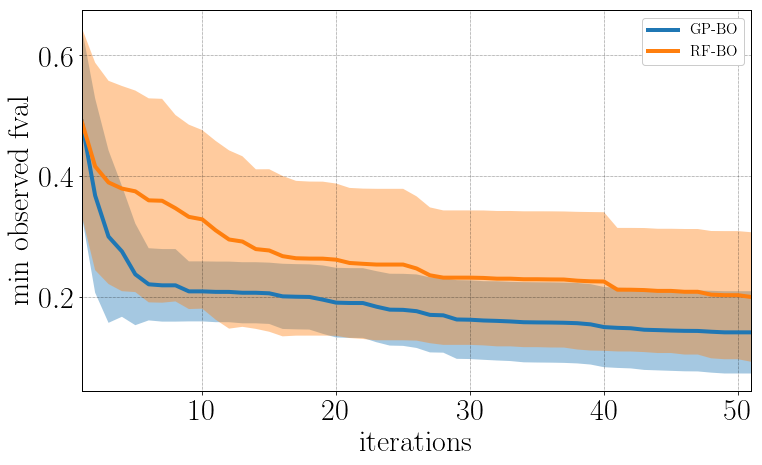

In [125]:
for index, m in enumerate(methods):
    
    fvals = benchmark_results.extract_metric_as_array(m[0], "minimum_observed_value")
    iters = np.arange(1, fvals.shape[1] + 1)
    plt.plot(iters, np.mean(fvals, axis=0), linewidth=4, label=m[0])
    plt.fill_between(iters, np.mean(fvals, axis=0) + np.std(fvals, axis=0),
                    np.mean(fvals, axis=0) - np.std(fvals, axis=0), alpha=0.4)

plt.legend()
plt.grid(True)
plt.xlabel("iterations")
plt.ylabel("min observed fval")
plt.xlim(iters[0], iters[-1])
plt.savefig("/home/kleinaa/talks/amazon_berlin_12_4_19/plots/auto_bench_1.pdf", bbox_inches='tight')


## Assessing performance across tasks

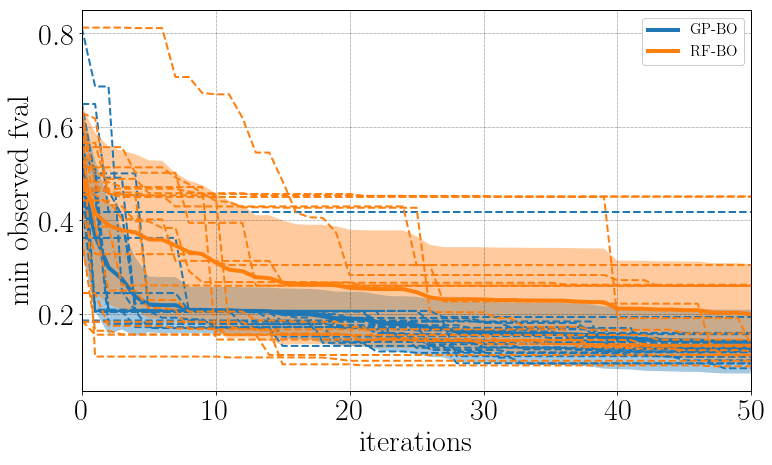

In [126]:
for index, m in enumerate(methods):
    
    fvals = benchmark_results.extract_metric_as_array(m[0], "minimum_observed_value")
    iters = np.arange(fvals.shape[1])
    plt.plot(iters, np.mean(fvals, axis=0), linewidth=4, label=m[0])
    [plt.plot(iters, fi, linewidth=2, color="C%d" % index, linestyle="--") for fi in fvals]
    plt.fill_between(iters, np.mean(fvals, axis=0) + np.std(fvals, axis=0),
                    np.mean(fvals, axis=0) - np.std(fvals, axis=0), alpha=0.4)

plt.legend()
plt.grid(True)
plt.xlabel("iterations")
plt.ylabel("min observed fval")
plt.xlim(iters[0], iters[-1])
plt.savefig("/home/kleinaa/talks/amazon_berlin_12_4_19/plots/auto_bench_2.pdf", bbox_inches='tight')


In [66]:
def compute_runtime_feval(trajectory, target):
    rt = np.where(trajectory <= target)[0]
    if len(rt) == 0:
        rt = np.inf
        return rt
    else:
        return rt[0] + 1

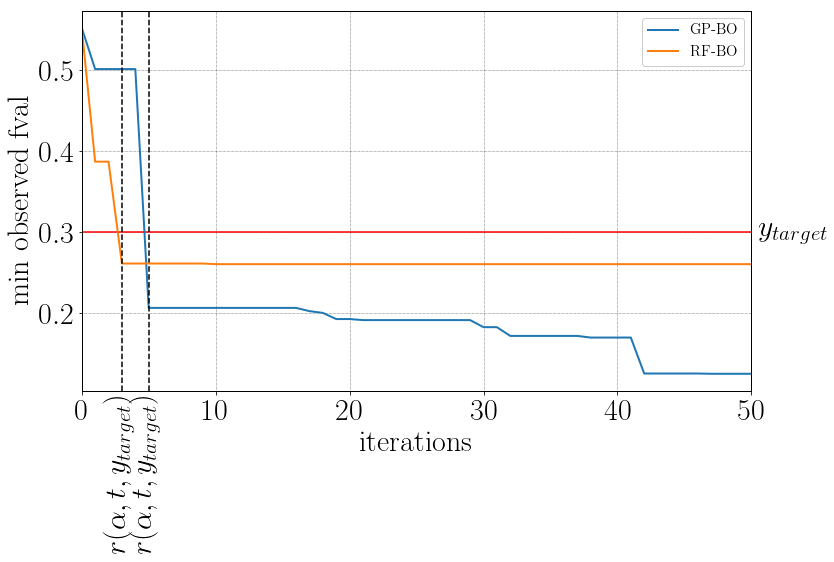

In [168]:
y_target = 0.3
plt.axhline(y_target, color="r")
plt.text(x=iters[-1] + 0.5, y=y_target-0.01, s=r"$y_{target}$", color='k')

for index, m in enumerate(methods):
    
    fvals = benchmark_results.extract_metric_as_array(m[0], "minimum_observed_value")
    
    plt.plot(iters, fvals[2], linewidth=2, label=m[0])
    
    r_t = compute_runtime_feval(fvals[1], y_target)
    plt.axvline(r_t, linestyle = "--", color="k")
    plt.text(x=r_t - 1.3, y=0.07, s=r"$r(\alpha, t, y_{target})$", color='k', rotation=90)
plt.legend()
plt.grid(True)

plt.xlabel("iterations")
plt.ylabel("min observed fval")
plt.xlim(iters[0], iters[-1])
plt.savefig("/home/kleinaa/talks/amazon_berlin_12_4_19/plots/auto_bench_3.pdf", bbox_inches='tight')


(array([[0.45757663]], dtype=float32), array([[160.10785]], dtype=float32))

In [120]:
import sys
import sobol_seq
bounds = np.array(parameter_space.get_bounds())

lower = bounds[:, 0]
upper = bounds[:, 1]

d = len(parameter_space.parameters)
X = sobol_seq.i4_sobol_generate(d, d * 100)
X = X * (upper - lower) + lower
targets = []
curr_best = np.inf
for xi in X:
    y = fcn(xi[None, :])[0][0][0]
    if y < curr_best:
        curr_best = y
    targets.append(curr_best)

targets = np.array(targets)
print(targets.shape)

(200,)


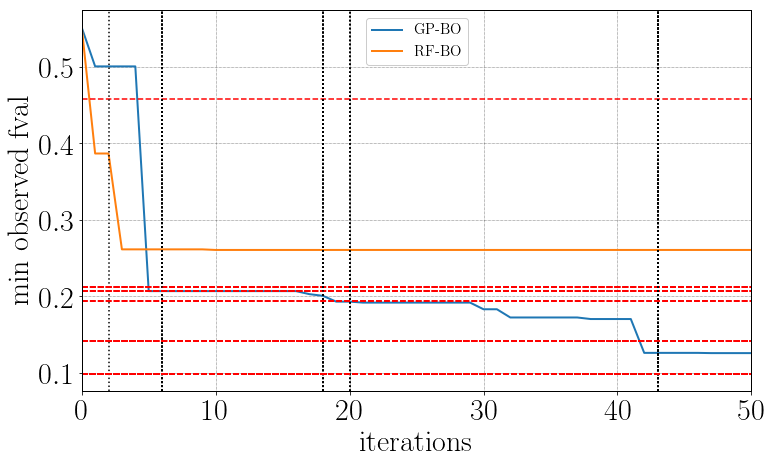

In [167]:

for index, m in enumerate(methods):

    fvals = benchmark_results.extract_metric_as_array(m[0], "minimum_observed_value")

    plt.plot(iters, fvals[2], linewidth=2, label=m[0])

for y_target in targets:
    
    plt.axhline(y_target, color="r", linestyle="--")
    for index, m in enumerate(methods):

        fvals = benchmark_results.extract_metric_as_array(m[0], "minimum_observed_value")

        r_t = compute_runtime_feval(fvals[2], y_target)
        plt.axvline(r_t, linestyle = ":", color="k")

plt.legend()
plt.grid(True)

plt.xlabel("iterations")
plt.ylabel("min observed fval")
plt.xlim(iters[0], iters[-1])
plt.savefig("/home/kleinaa/talks/amazon_berlin_12_4_19/plots/auto_bench_4.pdf", bbox_inches='tight')

## 4. References

- K. Eggensperger and F. Hutter and H. H. Hoos and K. Leyton-Brown, 2015. *Efficient Benchmarking of Hyperparameter Optimizers via Surrogates* Proceedings of the 29th National Conference on Artificial Intelligence (AAAI'15)

- M. Titsias and N. Lawrence, 2010. *Bayesian Gaussian process latent variable model* Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS'10)

- K. Swersky and J. Snoek and R. Adams, 2013. *Multi-task Bayesian optimization* Proceedings of the 26th International Conference on Advances in Neural Information Processing Systems (NIPS'13)

- J. T. Springenberg and A. Klein and S. Falkner and F. Hutter, 2016. *Bayesian Optimization with Robust Bayesian Neural Networks* Proceedings of the 29th International Conference on Advances in Neural Information Processing Systems (NIPS'16)